##### DNN CNN
    - 독립적인 정보
    - 입력(x) 간의 순서나 연관성을 고려하지 않는다
##### 시계열 : 시간의 연속적인 흐름
    - 시계열 데이터 : 날씨, 주식, 문장 --> 순서가 중요한 데이터
##### RNN 
    - 순환하는 구조
        - 시점1 (월요일) : 맑음(x1)  정보가 RNN에 들어온다 -> RNN 날씨가 맑았음(h1) 이라는 요약본을 생성
        - 시점2 (화요일) : 흐림(x2)  ->RNN 새로운정보(흐림, x2) + 어제의기억(맑았음, h1) 함께 고려
            어제 맑았는데 오늘 흐림 h2 이라는 새로운 요약본을 생성
        - 시점3 (수요일) : 비(x3) ->RNN 새로운정보(비, x3) 정보와 + 어제의기억(어제 맑았는데 오늘 흐림, h2) 새로운 상태 h3
        - 반복 
    - 알고리즘
        - 각 시점(time step)에서  1. 현재의 입력 과 2. 과거의 기억(hidden state ht-1) 받아서 3. 현재의 결과물과 4. 다음 시점으로 넘겨줄 최신 기억 ht 을 생성
        - ht 기억이 시계열 데이터의 맥락(Context) 저장하는 역할
    - 장점
        - 순서가 있는 데이터의 맥락을 학습
    - 한계
        - 기억력이 생각보다 짧다
        - 시계열 데이터가 길어지면(예 100단계 전의 정보)
        - 이전정보가 소실되거나 반대로 너무 강해져서 폭주가 되서 제대로 학습이 안된다
        - 장기 기억 의존성 문제 (Long-Term Dependency Problem)
##### LSTM & GRU
    - LSTM(Long Short Term Memory) : RNN 내부에 게이트(Gate) 복잡한 장치 -> 잊고, 기억할 정보를 관리
    - GRU(Gated Recurrent Unit) : LSTM 구조를 좀 더 단순화시킨 모델, LSTM성능은 비슷, 속도는 빠르다
##### RNN 핵심수식
    - 은닉상태계산
        - h1 = tanh(wht-1 + wxt - bh)
    - 출력계산

In [14]:
import pandas as pd
url = 'https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv'
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [15]:
# 전체 데이터셋 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [16]:
# EDA - 탐색적 데이터 분석

In [17]:
# 데이터셋 정의
import pandas as pd
import numpy as np
from torch.utils.data.dataset import Dataset
from sklearn.preprocessing import StandardScaler
import torch

class StockDataSet(Dataset):
    def __init__(self):
        url = 'https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv'
        self.csv = pd.read_csv(url)
        data = torch.Tensor(self.csv.iloc[: , 1: -1].values)
        label = torch.Tensor(self.csv.iloc[: , -1].values.reshape(-1, 1))
        self.data = StandardScaler().fit_transform(data)
        # 정답이 숫자 크다면 정규화가 학습에 도움이 된다.
        self.label = StandardScaler().fit_transform(label)
        self.data = torch.Tensor(self.data)
        self.label = torch.Tensor(self.label)
    def __len__(self):
        return len(self.data) - 30 # 사용가능한 배치 개수
    def __getitem__(self, index):
        data = self.data[index: index + 30]
        label = self.label[index + 30]
        return data, label

In [18]:
data, label = next(iter(StockDataSet()))
data.size(), label.size()

(torch.Size([30, 4]), torch.Size([1]))

In [19]:
from torch import nn
class StockRNN(nn.Module):
    def __init__(self):
        super(StockRNN, self).__init__()
        # (30일, 배치 16개, 각 입력의 특성 4개) batch_first = False
        # (배치 16개, 30일 각 입력의 특성 4개) batch_first = True
        self.rnn = nn.RNN(input_size=4, hidden_size=8, num_layers=5, batch_first=True)
        # 출력 (batch, 30, 8)
        self.fc1 = nn.Linear(30*8, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    def forward(self, x, ho): # 입력데이터는 (16,30,4)
        # ho = 초기 은닉 상태(num_layers, batch, hidden_size) (5,16,8)
        # 출력 x 는 모든 시점에 대한 hidden output을 담고 있어야함 (batch, seq_len, hidden_size) (16,30,8)
        # 출력 hn 최종은닉상태(각 레이어의 마지막 타임스탬프 hidden state) (num_layer, batch, hidden_state) (5,16,8)
        x, hn = self.rnn(x, ho)
        # mlp 입력으로 사용될 수 있도록 모양 변경
        x = torch.reshape(x, (x.shape[0], -1))
        # mlp 
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        # 예측한 종가 1차원 벡터
        out = torch.flatten(x)
        return out


In [20]:
rnn = StockRNN()
sample_data = torch.randn(16, 30, 4)
# 초기 hidden state 값  (num_layer, batch_size, hidden_size) (5, 16, 8)
ho = torch.zeros(5,16,8)
out = rnn(sample_data, ho)
out

tensor([0.0600, 0.0541, 0.0530, 0.0515, 0.0558, 0.0437, 0.0464, 0.0551, 0.0561,
        0.0521, 0.0500, 0.0467, 0.0529, 0.0434, 0.0589, 0.0530],
       grad_fn=<ViewBackward0>)

In [21]:
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StockRNN().to(device)
dataset = StockDataSet()
loader = DataLoader(dataset, batch_size=16)
optim = Adam(model.parameters(), lr=1e-3)

In [22]:
# Expected hidden size (5,9,8) got [5,16,8]
# Rnn이 처리하는 배치크기는 9, 우리가 설계한 ho 16
print(len(dataset) % 16)
# 마지막 배치 개수가 모자라서 9

9


In [23]:
# from tqdm import tqdm
# for epoch in range(200):
#     loop = tqdm(loader)
#     for data, label in loop:
#         optim.zero_grad() # 학습 다 끝냈는데 이전 기울기가 남아있는 상황 방지
#         # 초기 은닉 상태의 배치크기는 DataLoader가 주는 배치 크기
#         batch_size = data.size(0)

#         ho = torch.zeros(5,batch_size,8).to(device)
#         # 모델의 예측값
#         pred = model(data.to(device), ho)
#         # 손실값
#         loss = nn.MSELoss()(pred, label.to(device))
#         loss.backward()
#         optim.step()

#         loop.set_description(f'epoch: {epoch+1} loss: {loss.item()}')
# torch.save(model.state_dict(), './rnn.pth')


In [25]:
# 모델 성능평가하기
import matplotlib.pyplot as plt

loader = DataLoader(dataset,batch_size=1)
preds = []
total_loss = 0
with torch.no_grad():
    model.load_state_dict(torch.load('rnn.pth', map_location=device,weights_only=False))
    for data, label in loader:
        # 초기 은닉상태의 배치크기는 DataLoader가 주는 배치 크기
        batch_size = data.size(0)

        ho = torch.zeros(5,batch_size,8).to(device)
        # 모델의 예측값
        pred = model(data.to(device), ho)
        preds.append(pred.item())
        # 손실값
        loss = nn.MSELoss()(pred, label.to(device))
        total_loss += (loss.item() / len(loader))

print(f'total_loss : {total_loss:.4f}')

c:\Users\playdata2\miniconda3\envs\deep\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total_loss : 0.0328


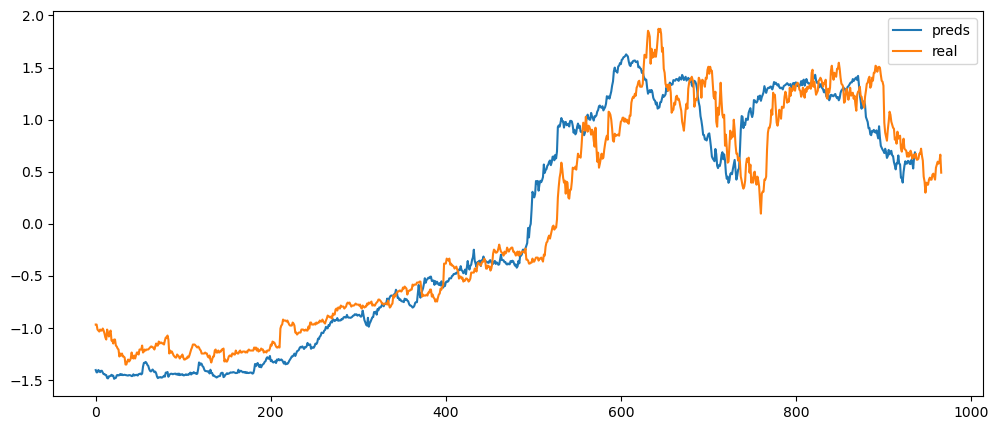

In [26]:
plt.figure(figsize=(12,5))
plt.plot(preds, label='preds')
plt.plot(dataset.label, label='real')
plt.legend()
plt.show()